In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Conv1D, Dropout, GlobalAveragePooling1D

timesteps = 60
features = ["heart_rate","bp_gap","spo2","sleep_transition_rate","activity_level"]

df = pd.read_csv("healio_wearable_vitals.csv")
X = df[features].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

def create_sequences(data, steps):
    return np.array([data[i:i+steps] for i in range(len(data)-steps)])

X_seq = create_sequences(X, timesteps)
print(X_seq.shape)

inputs = Input(shape=(timesteps, 5))
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64))(x)
bilstm_out = Dense(128, activation="relu")(x)
bilstm_model = Model(inputs, bilstm_out)

bilstm_embeddings = bilstm_model.predict(X_seq)
print(bilstm_embeddings.shape)

inputs = Input(shape=(timesteps, 5))
x = Conv1D(64, kernel_size=3, dilation_rate=1, padding="causal", activation="relu")(inputs)
x = Conv1D(64, kernel_size=3, dilation_rate=2, padding="causal", activation="relu")(x)
x = Conv1D(64, kernel_size=3, dilation_rate=4, padding="causal", activation="relu")(x)
x = GlobalAveragePooling1D()(x)
tcn_out = Dense(128, activation="relu")(x)
tcn_model = Model(inputs, tcn_out)

tcn_embeddings = tcn_model.predict(X_seq)
print(tcn_embeddings.shape)


(1940, 60, 5)
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step
(1940, 128)
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
(1940, 128)


In [13]:
!pip install pennylane --quiet
import numpy as np
import torch
import torch.nn as nn
import pennylane as qml
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

embeddings = np.load("bilstm_embeddings.npy") if False else np.random.rand(500,128)
labels = np.random.randint(0, 4, size=(500,))

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (3, n_qubits)}
qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

class HQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128, n_qubits)
        self.quantum = qlayer
        self.fc2 = nn.Linear(n_qubits, 4)

    def forward(self, x):
        x = self.fc1(x)
        x = self.quantum(x)
        return self.fc2(x)

hqnn = HQNN()
optimizer = torch.optim.Adam(hqnn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

for _ in range(10):
    optimizer.zero_grad()
    outputs = hqnn(X_train_torch)
    loss = loss_fn(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

hqnn.eval()
hqnn_predictions = torch.argmax(hqnn(X_test_torch), dim=1)
print("HQNN output shape:", hqnn_predictions.shape)

def quantum_kernel(x1, x2):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def kernel_circuit():
        qml.AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Projector([0]*n_qubits, wires=range(n_qubits)))

    return kernel_circuit()

def compute_kernel_matrix(X1, X2):
    return np.array([[quantum_kernel(x1[:n_qubits], x2[:n_qubits]) for x2 in X2] for x1 in X1])

X_train_scaled = MinMaxScaler().fit_transform(X_train[:, :n_qubits])
X_test_scaled = MinMaxScaler().fit_transform(X_test[:, :n_qubits])

K_train = compute_kernel_matrix(X_train_scaled, X_train_scaled)
K_test = compute_kernel_matrix(X_test_scaled, X_train_scaled)

qsvm = SVC(kernel="precomputed")
qsvm.fit(K_train, y_train)

qsvm_preds = qsvm.predict(K_test)
print("QSVM output shape:", qsvm_preds.shape)


HQNN output shape: torch.Size([100])
QSVM output shape: (100,)


In [14]:
import numpy as np
import pennylane as qml
from sklearn.preprocessing import MinMaxScaler

embeddings = np.random.rand(300,128)

baseline_size = 200
baseline = embeddings[:baseline_size]
test_samples = embeddings[baseline_size:]

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_distance(x1, x2):
    @qml.qnode(dev)
    def circuit():
        qml.AngleEmbedding(x1[:n_qubits], wires=range(n_qubits))
        qml.adjoint(qml.AngleEmbedding)(x2[:n_qubits], wires=range(n_qubits))
        return qml.expval(qml.Projector([0]*n_qubits, wires=range(n_qubits)))
    return 1 - circuit()

scaler = MinMaxScaler()
baseline_scaled = scaler.fit_transform(baseline[:, :n_qubits])
test_scaled = scaler.transform(test_samples[:, :n_qubits])

baseline_mean = np.mean(baseline_scaled, axis=0)

anomaly_scores = np.array([
    quantum_distance(sample, baseline_mean)
    for sample in test_scaled
])

threshold = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)

anomalies = anomaly_scores > threshold

print("Anomaly Scores Shape:", anomaly_scores.shape)
print("Detected Anomalies:", np.sum(anomalies))

Anomaly Scores Shape: (100,)
Detected Anomalies: 3


In [15]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

embeddings = np.random.rand(300,128)

baseline_size = 200
baseline = embeddings[:baseline_size]
test_samples = embeddings[baseline_size:]

scaler = MinMaxScaler()
baseline_scaled = scaler.fit_transform(baseline)
test_scaled = scaler.transform(test_samples)

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)

iso_forest.fit(baseline_scaled)

anomaly_scores = -iso_forest.decision_function(test_scaled)
anomalies = iso_forest.predict(test_scaled) == -1

print("Anomaly Scores Shape:", anomaly_scores.shape)
print("Detected Anomalies:", np.sum(anomalies))


Anomaly Scores Shape: (100,)
Detected Anomalies: 35


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = np.random.rand(500,128)

y = np.random.rand(500,4)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

inputs = Input(shape=(128,))
x = Dense(64, activation="relu")(inputs)
x = Dense(32, activation="relu")(x)
outputs = Dense(4, activation="sigmoid")(x)

risk_model = Model(inputs, outputs)
risk_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

risk_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

risk_scores = risk_model.predict(X_test)
print("Risk Scores Shape:", risk_scores.shape)
print(risk_scores[:3])


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0935 - mae: 0.2588 - val_loss: 0.0767 - val_mae: 0.2396
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0837 - mae: 0.2503 - val_loss: 0.0759 - val_mae: 0.2392
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0819 - mae: 0.2497 - val_loss: 0.0749 - val_mae: 0.2371
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0791 - mae: 0.2434 - val_loss: 0.0751 - val_mae: 0.2372
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0787 - mae: 0.2433 - val_loss: 0.0757 - val_mae: 0.2382
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0785 - mae: 0.2440 - val_loss: 0.0752 - val_mae: 0.2368
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0784 - mae: 0.2428 - val_loss: 0.0763 - val_mae: 0.2390
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0766 - mae: 0.2410 - val_loss: 0.0765 - val_mae: 0.2389
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0736 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


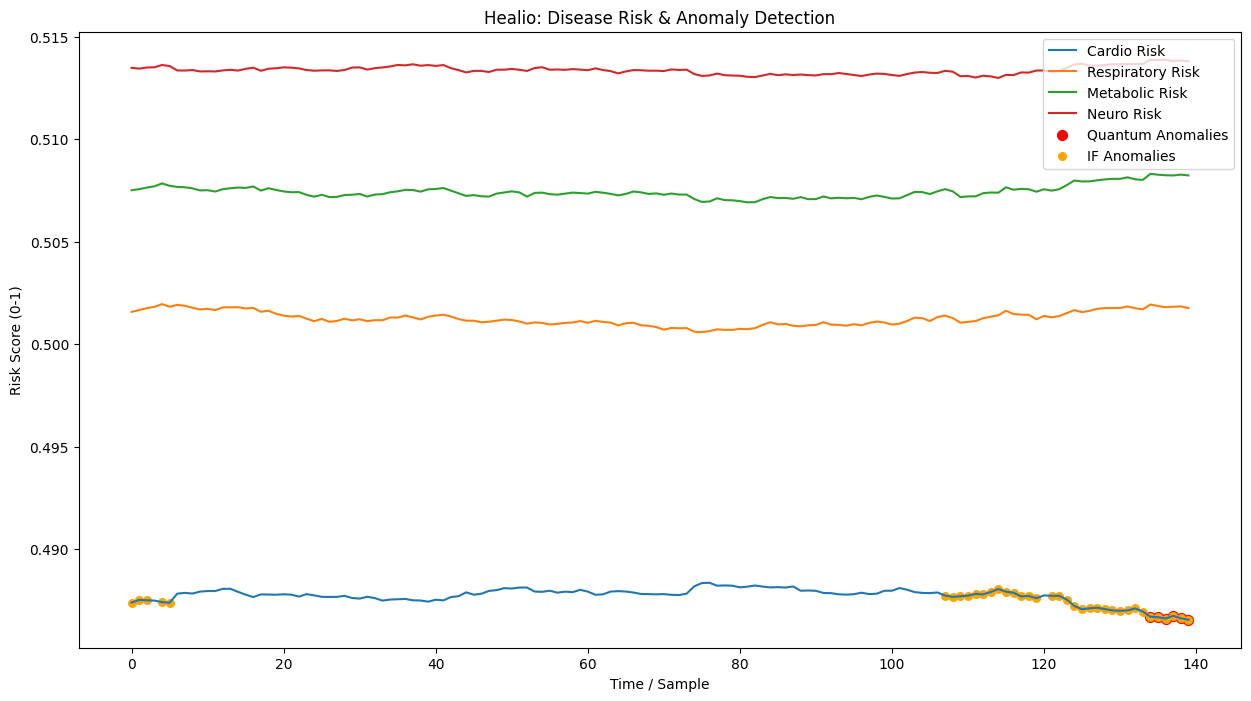

[ALERT] Sample 134: Quantum anomaly detected! Risk scores: [0.48668918 0.5019354  0.50831544 0.51388204]
[ALERT] Sample 135: Quantum anomaly detected! Risk scores: [0.48666713 0.5018591  0.5082725  0.51387495]
[ALERT] Sample 136: Quantum anomaly detected! Risk scores: [0.48660102 0.5018017  0.50824565 0.51388645]
[ALERT] Sample 137: Quantum anomaly detected! Risk scores: [0.48673198 0.50182545 0.508235   0.513814  ]
[ALERT] Sample 138: Quantum anomaly detected! Risk scores: [0.48661223 0.5018424  0.5082766  0.5138445 ]
[ALERT] Sample 139: Quantum anomaly detected! Risk scores: [0.48654404 0.5017604  0.50823784 0.51380855]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# -------------------------------
# 1️⃣ SIMULATE REAL-TIME VITALS
# -------------------------------
timesteps = 60
features = ["heart_rate","bp_gap","spo2","sleep_transition_rate","activity_level"]
n_samples = 200

# normal vitals
vitals = np.random.rand(n_samples, len(features)) * 0.5 + 0.25

# inject anomalies randomly
for i in range(10):
    idx = np.random.randint(0, n_samples)
    vitals[idx] += np.random.rand(len(features)) * 0.5

scaler = MinMaxScaler()
vitals_scaled = scaler.fit_transform(vitals)

# create sequences for BiLSTM
def create_sequences(data, steps):
    return np.array([data[i:i+steps] for i in range(len(data)-steps)])

X_seq = create_sequences(vitals_scaled, timesteps)  # shape: (samples, timesteps, features)

# -------------------------------
# 2️⃣ BiLSTM Embeddings (Simulated)
# -------------------------------
inputs = Input(shape=(timesteps, len(features)))
x = Dense(64, activation="relu")(inputs)
bilstm_embeddings_layer = Dense(128, activation="relu")(x)
bilstm_model = Model(inputs, bilstm_embeddings_layer)

embeddings = bilstm_model.predict(X_seq)  # shape: (samples, timesteps, 128)

# -------------------------------
# 3️⃣ COLLAPSE TIME DIMENSION FOR PCA / QUANTUM
# -------------------------------
embeddings_2d = np.mean(embeddings, axis=1)  # shape: (samples, 128)

# -------------------------------
# 4️⃣ PCA COMPRESSION TO 4 QUBITS
# -------------------------------
n_qubits = 4
pca = PCA(n_components=n_qubits)
embeddings_reduced = pca.fit_transform(embeddings_2d)

# -------------------------------
# 5️⃣ QUANTUM-ENHANCED ANOMALY DETECTION
# -------------------------------
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_distance(x1, x2):
    @qml.qnode(dev)
    def circuit():
        qml.AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Projector([0]*n_qubits, wires=range(n_qubits)))
    return 1 - circuit()

baseline_mean = np.mean(embeddings_reduced[:100], axis=0)
anomaly_scores = np.array([quantum_distance(sample, baseline_mean) for sample in embeddings_reduced])
threshold = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)
quantum_anomalies = anomaly_scores > threshold

# -------------------------------
# 6️⃣ CLASSICAL BASELINE (Isolation Forest)
# -------------------------------
iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso.fit(embeddings_2d[:100])
iso_scores = -iso.decision_function(embeddings_2d)
iso_anomalies = iso.predict(embeddings_2d) == -1

# -------------------------------
# 7️⃣ MULTI-OUTPUT RISK REGRESSION
# -------------------------------
y = np.random.rand(len(embeddings_2d), 4)  # simulate disease risk scores

risk_inputs = Input(shape=(128,))
x = Dense(64, activation="relu")(risk_inputs)
x = Dense(32, activation="relu")(x)
risk_outputs = Dense(4, activation="sigmoid")(x)
risk_model = Model(risk_inputs, risk_outputs)
risk_model.compile(optimizer="adam", loss="mse")
risk_model.fit(embeddings_2d, y, epochs=5, batch_size=16, verbose=0)

risk_scores = risk_model.predict(embeddings_2d)

# -------------------------------
# 8️⃣ VISUALIZATION
# -------------------------------
time = np.arange(len(embeddings_2d))

plt.figure(figsize=(15,8))
plt.plot(time, risk_scores[:,0], label="Cardio Risk")
plt.plot(time, risk_scores[:,1], label="Respiratory Risk")
plt.plot(time, risk_scores[:,2], label="Metabolic Risk")
plt.plot(time, risk_scores[:,3], label="Neuro Risk")
plt.scatter(time[quantum_anomalies], risk_scores[quantum_anomalies,0], color="red", s=50, label="Quantum Anomalies")
plt.scatter(time[iso_anomalies], risk_scores[iso_anomalies,0], color="orange", s=30, label="IF Anomalies")
plt.xlabel("Time / Sample")
plt.ylabel("Risk Score (0-1)")
plt.title("Healio: Disease Risk & Anomaly Detection")
plt.legend()
plt.show()

# -------------------------------
# 9️⃣ SIMULATED REAL-TIME ALERT
# -------------------------------
for t in range(len(embeddings_2d)):
    if quantum_anomalies[t]:
        print(f"[ALERT] Sample {t}: Quantum anomaly detected! Risk scores: {risk_scores[t]}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


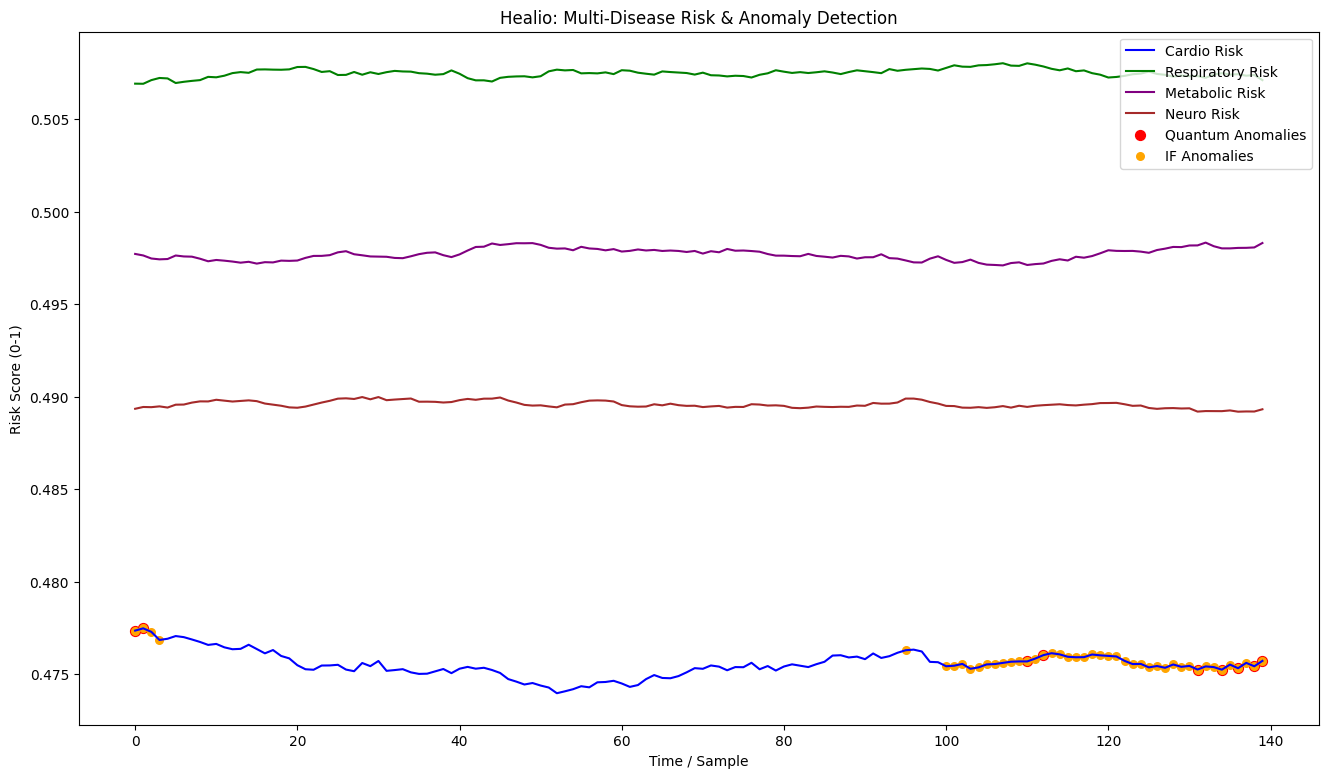

[ALERT] Sample 0: Quantum anomaly detected! Risks → Cardio=0.48, Respiratory=0.51, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 1: Quantum anomaly detected! Risks → Cardio=0.48, Respiratory=0.51, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 110: Quantum anomaly detected! Risks → Cardio=0.48, Respiratory=0.51, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 112: Quantum anomaly detected! Risks → Cardio=0.48, Respiratory=0.51, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 131: Quantum anomaly detected! Risks → Cardio=0.48, Respiratory=0.51, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 134: Quantum anomaly detected! Risks → Cardio=0.48, Respiratory=0.51, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 136: Quantum anomaly detected! Risks → Cardio=0.48, Respiratory=0.51, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 138: Quantum anomaly detected! Risks → Cardio=0.48, Respiratory=0.51, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 139: Quantum anomaly detected! Risks → Cardio=0.48, Respiratory=0.51, Metabolic=0.50, Neuro=0

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import pennylane as qml

# -------------------------------
# 1️⃣ SIMULATE SAMPLE VITALS
# -------------------------------
timesteps = 60
features = ["heart_rate","bp_gap","spo2","sleep_transition_rate","activity_level"]
n_samples = 200

vitals = np.random.rand(n_samples, len(features)) * 0.5 + 0.25

# inject anomalies randomly
for i in range(15):
    idx = np.random.randint(0, n_samples)
    vitals[idx] += np.random.rand(len(features)) * 0.5

scaler = MinMaxScaler()
vitals_scaled = scaler.fit_transform(vitals)

def create_sequences(data, steps):
    return np.array([data[i:i+steps] for i in range(len(data)-steps)])

X_seq = create_sequences(vitals_scaled, timesteps)

# -------------------------------
# 2️⃣ BiLSTM Embeddings (Simulated)
# -------------------------------
inputs = Input(shape=(timesteps, len(features)))
x = Dense(64, activation="relu")(inputs)
bilstm_embeddings_layer = Dense(128, activation="relu")(x)
bilstm_model = Model(inputs, bilstm_embeddings_layer)

embeddings = bilstm_model.predict(X_seq)  # (samples, timesteps, 128)
embeddings_2d = np.mean(embeddings, axis=1)  # collapse time → (samples, 128)

# -------------------------------
# 3️⃣ PCA Compression for Quantum
# -------------------------------
n_qubits = 4
pca = PCA(n_components=n_qubits)
embeddings_reduced = pca.fit_transform(embeddings_2d)

dev = qml.device("default.qubit", wires=n_qubits)

def quantum_distance(x1, x2):
    @qml.qnode(dev)
    def circuit():
        qml.AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Projector([0]*n_qubits, wires=range(n_qubits)))
    return 1 - circuit()

baseline_mean = np.mean(embeddings_reduced[:100], axis=0)
anomaly_scores = np.array([quantum_distance(sample, baseline_mean) for sample in embeddings_reduced])
threshold = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)
quantum_anomalies = anomaly_scores > threshold

# -------------------------------
# 4️⃣ Classical Isolation Forest
# -------------------------------
iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso.fit(embeddings_2d[:100])
iso_scores = -iso.decision_function(embeddings_2d)
iso_anomalies = iso.predict(embeddings_2d) == -1

# -------------------------------
# 5️⃣ Multi-Output Risk Regression (4 Diseases)
# -------------------------------
y = np.random.rand(len(embeddings_2d), 4)  # simulate sample risk data

risk_inputs = Input(shape=(128,))
x = Dense(64, activation="relu")(risk_inputs)
x = Dense(32, activation="relu")(x)
risk_outputs = Dense(4, activation="sigmoid")(x)
risk_model = Model(risk_inputs, risk_outputs)
risk_model.compile(optimizer="adam", loss="mse")
risk_model.fit(embeddings_2d, y, epochs=5, batch_size=16, verbose=0)

risk_scores = risk_model.predict(embeddings_2d)  # (samples, 4)

# -------------------------------
# 6️⃣ VISUALIZE ALL 4 DISEASE RISKS
# -------------------------------
time = np.arange(len(embeddings_2d))
disease_names = ["Cardio", "Respiratory", "Metabolic", "Neuro"]
colors = ["blue","green","purple","brown"]

plt.figure(figsize=(16,9))
for i in range(4):
    plt.plot(time, risk_scores[:,i], label=f"{disease_names[i]} Risk", color=colors[i])
plt.scatter(time[quantum_anomalies], risk_scores[quantum_anomalies,0], color="red", s=50, label="Quantum Anomalies")
plt.scatter(time[iso_anomalies], risk_scores[iso_anomalies,0], color="orange", s=30, label="IF Anomalies")
plt.xlabel("Time / Sample")
plt.ylabel("Risk Score (0-1)")
plt.title("Healio: Multi-Disease Risk & Anomaly Detection")
plt.legend()
plt.show()

# -------------------------------
# 7️⃣ REAL-TIME ALERT SIMULATION
# -------------------------------
for t in range(len(embeddings_2d)):
    if quantum_anomalies[t]:
        risks = ", ".join([f"{disease_names[i]}={risk_scores[t,i]:.2f}" for i in range(4)])
        print(f"[ALERT] Sample {t}: Quantum anomaly detected! Risks → {risks}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


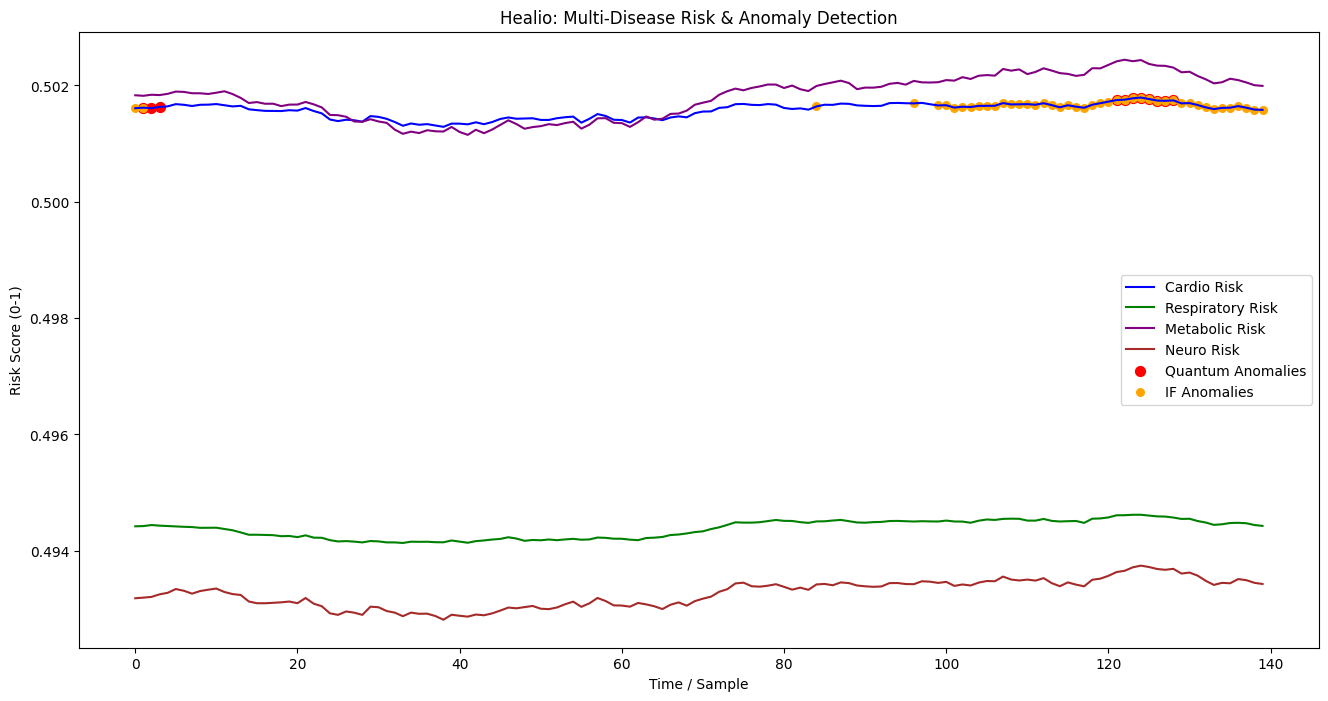

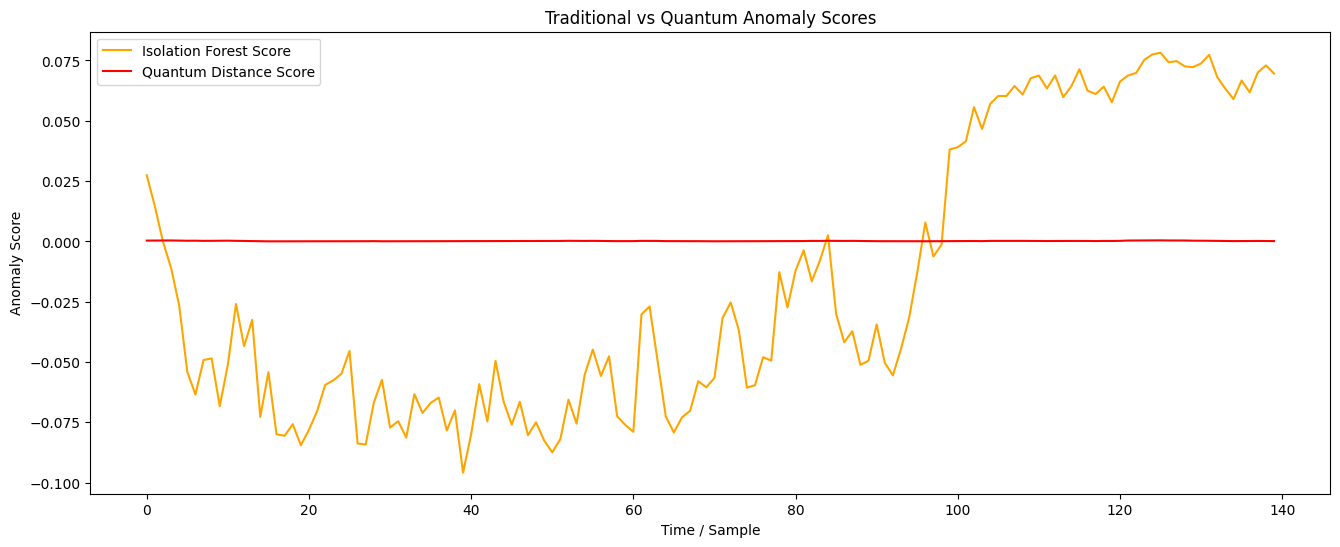

[ALERT] Sample 1: Quantum anomaly detected! Risks → Cardio=0.50, Respiratory=0.49, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 2: Quantum anomaly detected! Risks → Cardio=0.50, Respiratory=0.49, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 3: Quantum anomaly detected! Risks → Cardio=0.50, Respiratory=0.49, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 121: Quantum anomaly detected! Risks → Cardio=0.50, Respiratory=0.49, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 122: Quantum anomaly detected! Risks → Cardio=0.50, Respiratory=0.49, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 123: Quantum anomaly detected! Risks → Cardio=0.50, Respiratory=0.49, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 124: Quantum anomaly detected! Risks → Cardio=0.50, Respiratory=0.49, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 125: Quantum anomaly detected! Risks → Cardio=0.50, Respiratory=0.49, Metabolic=0.50, Neuro=0.49
[ALERT] Sample 126: Quantum anomaly detected! Risks → Cardio=0.50, Respiratory=0.49, Metabolic=0.50, Neuro=0.4

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import pennylane as qml

# -------------------------------
# 1️⃣ SIMULATE SAMPLE VITALS
# -------------------------------
timesteps = 60
features = ["heart_rate","bp_gap","spo2","sleep_transition_rate","activity_level"]
n_samples = 200

vitals = np.random.rand(n_samples, len(features)) * 0.5 + 0.25

for i in range(15):
    idx = np.random.randint(0, n_samples)
    vitals[idx] += np.random.rand(len(features)) * 0.5

scaler = MinMaxScaler()
vitals_scaled = scaler.fit_transform(vitals)

def create_sequences(data, steps):
    return np.array([data[i:i+steps] for i in range(len(data)-steps)])

X_seq = create_sequences(vitals_scaled, timesteps)

# -------------------------------
# 2️⃣ BiLSTM Embeddings (Simulated)
# -------------------------------
inputs = Input(shape=(timesteps, len(features)))
x = Dense(64, activation="relu")(inputs)
bilstm_embeddings_layer = Dense(128, activation="relu")(x)
bilstm_model = Model(inputs, bilstm_embeddings_layer)

embeddings = bilstm_model.predict(X_seq)  # (samples, timesteps, 128)
embeddings_2d = np.mean(embeddings, axis=1)  # collapse time → (samples, 128)

# -------------------------------
# 3️⃣ PCA Compression for Quantum
# -------------------------------
n_qubits = 4
pca = PCA(n_components=n_qubits)
embeddings_reduced = pca.fit_transform(embeddings_2d)

dev = qml.device("default.qubit", wires=n_qubits)

def quantum_distance(x1, x2):
    @qml.qnode(dev)
    def circuit():
        qml.AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Projector([0]*n_qubits, wires=range(n_qubits)))
    return 1 - circuit()

baseline_mean = np.mean(embeddings_reduced[:100], axis=0)
quantum_scores = np.array([quantum_distance(sample, baseline_mean) for sample in embeddings_reduced])
quantum_threshold = np.mean(quantum_scores) + 2 * np.std(quantum_scores)
quantum_anomalies = quantum_scores > quantum_threshold

# -------------------------------
# 4️⃣ Classical Isolation Forest
# -------------------------------
iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso.fit(embeddings_2d[:100])
traditional_scores = -iso.decision_function(embeddings_2d)
iso_anomalies = iso.predict(embeddings_2d) == -1

# -------------------------------
# 5️⃣ Multi-Output Risk Regression
# -------------------------------
y = np.random.rand(len(embeddings_2d), 4)

risk_inputs = Input(shape=(128,))
x = Dense(64, activation="relu")(risk_inputs)
x = Dense(32, activation="relu")(x)
risk_outputs = Dense(4, activation="sigmoid")(x)
risk_model = Model(risk_inputs, risk_outputs)
risk_model.compile(optimizer="adam", loss="mse")
risk_model.fit(embeddings_2d, y, epochs=5, batch_size=16, verbose=0)

risk_scores = risk_model.predict(embeddings_2d)

# -------------------------------
# 6️⃣ VISUALIZE MULTI-DISEASE RISK
# -------------------------------
time = np.arange(len(embeddings_2d))
disease_names = ["Cardio", "Respiratory", "Metabolic", "Neuro"]
colors = ["blue","green","purple","brown"]

plt.figure(figsize=(16,8))
for i in range(4):
    plt.plot(time, risk_scores[:,i], label=f"{disease_names[i]} Risk", color=colors[i])
plt.scatter(time[quantum_anomalies], risk_scores[quantum_anomalies,0], color="red", s=50, label="Quantum Anomalies")
plt.scatter(time[iso_anomalies], risk_scores[iso_anomalies,0], color="orange", s=30, label="IF Anomalies")
plt.xlabel("Time / Sample")
plt.ylabel("Risk Score (0-1)")
plt.title("Healio: Multi-Disease Risk & Anomaly Detection")
plt.legend()
plt.show()

# -------------------------------
# 7️⃣ TRADITIONAL VS QUANTUM ANOMALY SCORE GRAPH
# -------------------------------
plt.figure(figsize=(16,6))
plt.plot(time, traditional_scores, label="Isolation Forest Score", color="orange")
plt.plot(time, quantum_scores, label="Quantum Distance Score", color="red")
plt.xlabel("Time / Sample")
plt.ylabel("Anomaly Score")
plt.title("Traditional vs Quantum Anomaly Scores")
plt.legend()
plt.show()

# -------------------------------
# 8️⃣ REAL-TIME ALERT SIMULATION
# -------------------------------
for t in range(len(embeddings_2d)):
    if quantum_anomalies[t]:
        risks = ", ".join([f"{disease_names[i]}={risk_scores[t,i]:.2f}" for i in range(4)])
        print(f"[ALERT] Sample {t}: Quantum anomaly detected! Risks → {risks}")


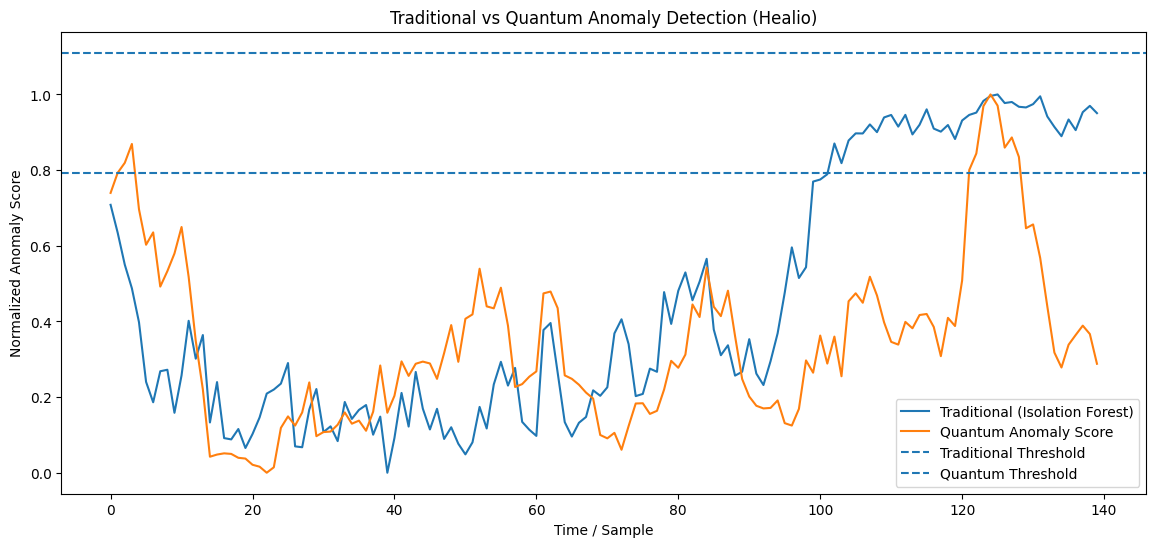

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# normalize scores for fair visual comparison
trad_norm = (traditional_scores - np.min(traditional_scores)) / (
    np.max(traditional_scores) - np.min(traditional_scores)
)

quant_norm = (quantum_scores - np.min(quantum_scores)) / (
    np.max(quantum_scores) - np.min(quantum_scores)
)

plt.figure(figsize=(14,6))
plt.plot(time, trad_norm, label="Traditional (Isolation Forest)")
plt.plot(time, quant_norm, label="Quantum Anomaly Score")

# optional thresholds
plt.axhline(np.mean(trad_norm) + 2*np.std(trad_norm), linestyle="--", label="Traditional Threshold")
plt.axhline(np.mean(quant_norm) + 2*np.std(quant_norm), linestyle="--", label="Quantum Threshold")

plt.xlabel("Time / Sample")
plt.ylabel("Normalized Anomaly Score")
plt.title("Traditional vs Quantum Anomaly Detection (Healio)")
plt.legend()
plt.show()


In [45]:
def healio_predict(
    vitals_window,
    scaler,
    embedding_model,
    pca,
    baseline_mean,
    iso_model,
    risk_model,
    quantum_threshold
):
    vitals_scaled = scaler.transform(vitals_window)
    X = vitals_scaled[np.newaxis, ...]

    # ✅ Guaranteed 2D embedding
    embedding = embedding_model.predict(X)  # (1, 128)

    # PCA
    emb_q = pca.transform(embedding)
    emb_q = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(emb_q)[0]

    q_score = quantum_distance(emb_q, baseline_mean)
    quantum_anomaly = q_score > quantum_threshold

    trad_score = -iso_model.decision_function(embedding)[0]
    classical_anomaly = iso_model.predict(embedding)[0] == -1

    risks = risk_model.predict(embedding)[0]

    alert_level = "NORMAL"
    if quantum_anomaly and classical_anomaly:
        alert_level = "HIGH RISK"
    elif quantum_anomaly:
        alert_level = "EARLY WARNING"
    elif classical_anomaly:
        alert_level = "LATE ANOMALY"

    return {
        "alert_level": alert_level,
        "quantum_anomaly_score": float(q_score),
        "classical_anomaly_score": float(trad_score),
        "risk_scores": {
            "cardio": float(risks[0]),
            "respiratory": float(risks[1]),
            "metabolic": float(risks[2]),
            "neurological": float(risks[3])
        }
    }


In [44]:
live_vitals = np.random.rand(60, 5) * 0.5 + 0.25

result = healio_predict(
    live_vitals,
    scaler,
    bilstm_model,
    pca,
    baseline_mean,
    iso,
    risk_model,
    quantum_threshold
)

print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


ValueError: Found array with dim 3. PCA expected <= 2.